COPYRIGHT © 2018 Kiran Arun <kironni@gmail.com>

### Setup

In [1]:
# install dependencies
!rm -r Neural_Networks-101-demo
!git clone -b explanations https://github.com/KiranArun/Neural_Networks-101-demo.git
!python3 /content/Neural_Networks-101-demo/scripts/setup.py helper_funcs tensorboard

Cloning into 'Neural_Networks-101-demo'...
remote: Counting objects: 352, done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 352 (delta 30), reused 57 (delta 14), pack-reused 271
Receiving objects: 100% (352/352), 7.53 MiB | 19.26 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Getting helper functions...


In [2]:
# run tensorboard
get_ipython().system_raw('tensorboard --logdir=/content/logdir/ --host=0.0.0.0 --port=6006 &')
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print('Tensorboard Link:', json.load(sys.stdin)['tunnels'][0]['public_url'])"

Tensorboard Link: http://bdb495ac.ngrok.io


# MNIST Handwriten Digits Classifier

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from math import ceil,floor
import helper_funcs as helper

In [4]:
# this is the directory where we will keep and external files, eg. data, logs
model_root_dir = '/content/'

# get data
mnist = helper.MNIST_data(model_root_dir+'MNIST_data/',shuffle=False)

Download complete.
Save complete.


In [0]:
image_dims = (28,28)
input_size = 28**2
num_classes = 10

In [0]:
batch_size = 100
learning_rate = 0.1

epochs = 2
iterations = ceil(mnist.number_train_samples/batch_size)

hidden_size = 256
embedding_size = 10

In [0]:
model_logdir = model_root_dir+'logdir/'

LABELS = os.path.join(os.getcwd(), model_logdir+"labels_1024.tsv")
SPRITES = os.path.join(os.getcwd(), model_logdir+"sprite_1024.png")

hparam_str = 'fc2,lr_%f' % (learning_rate)
previous_runs = list(f for f in os.listdir(model_logdir) if f.startswith('run'))

if len(previous_runs) == 0:
    run_number = 1  
else:
    run_number = max([int(s[4:6]) for s in previous_runs]) + 1

LOGDIR = '%srun_%02d,' % (model_logdir, run_number)+hparam_str

In [0]:
tf.reset_default_graph()

In [0]:
with tf.name_scope('input'):
    X_placeholder = tf.placeholder(shape=[None, input_size], dtype=tf.float32, name='X_placeholder')
    Y_placeholder = tf.placeholder(shape=[None, num_classes], dtype=tf.int64, name='Y_placeholder')

with tf.name_scope('input_reshaped'):
    X_image = tf.reshape(X_placeholder, shape=[-1,*image_dims, 1])
    tf.summary.image('input', X_image, 3)

In [0]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [0]:
with tf.name_scope('hidden_layer'):
    
    with tf.name_scope('Weights'):
        W1 = tf.Variable(tf.truncated_normal(shape=[input_size, hidden_size]), dtype=tf.float32, name='W1')
        variable_summaries(W1)
        
    with tf.name_scope('biases'):
        b1 = tf.Variable(tf.constant(0.1,shape=[hidden_size]), dtype=tf.float32, name='b1')
        variable_summaries(b1)
        
    with tf.name_scope('output'):
        hidden_output = tf.nn.relu(tf.matmul(X_placeholder, W1) + b1)

In [0]:
with tf.name_scope('output_layer'):
    
    with tf.name_scope('Weights'):
        W2 = tf.Variable(tf.truncated_normal(shape=[hidden_size, num_classes]), dtype=tf.float32, name='W2')
        variable_summaries(W2)
        
    with tf.name_scope('biases'):
        b2 = tf.Variable(tf.constant(0.1,shape=[num_classes]), dtype=tf.float32, name='b2')
        variable_summaries(b2)
        
    with tf.name_scope('output'):
        Y_predictions = tf.matmul(hidden_output, W2) + b2
        
    embedding_input = Y_predictions

In [0]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_placeholder,
                                                               logits=Y_predictions,
                                                               name='cross_entropy')
    
    loss = tf.reduce_mean(cross_entropy)
    tf.summary.scalar('loss', loss)

with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [0]:
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_predictions'):
        correct_prediction = tf.equal(tf.argmax(Y_predictions, 1), tf.argmax(Y_placeholder, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

In [0]:
sess = tf.InteractiveSession()

In [0]:
summ = tf.summary.merge_all()

embedding = tf.Variable(tf.zeros([1024, embedding_size]), name="embedding")
assignment = embedding.assign(embedding_input)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter(LOGDIR)
writer.add_graph(sess.graph)

config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
embedding_config = config.embeddings.add()
embedding_config.tensor_name = embedding.name
embedding_config.sprite.image_path = SPRITES
embedding_config.metadata_path = LABELS
embedding_config.sprite.single_image_dim.extend([*image_dims])
tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)

In [17]:
losses = np.array([])

for epoch in range(epochs):
    
    print('New epoch', str(epoch+1)+'/'+str(epochs))

    for iteration in range(iterations):

        batch_xs, batch_ys = mnist.get_batch(iteration, batch_size)

        _, _loss, _summary = sess.run([train_step, loss, summ], 
                            feed_dict={
                                X_placeholder: batch_xs,
                                Y_placeholder: batch_ys
                            })

        if (iteration+1) % (iterations/5) == 0:

            _accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.validation_images,
                                                      Y_placeholder : mnist.validation_labels
                                                     })

            print('step', str(iteration+1)+'/'+str(iterations), 'loss', _loss, 'accuracy', str(round(100*_accuracy,2))+'%')

        if iteration % 10 == 0:
            writer.add_summary(_summary, (epoch*iterations)+iteration)
            
        losses = np.append(losses, _loss)

    sess.run(assignment, feed_dict={X_placeholder: mnist.test_images[:1024], Y_placeholder: mnist.test_labels[:1024]})
    saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), (epoch*iterations)+iteration)

New epoch 1/2
step 110/550 loss 3.44714 accuracy 86.6%
step 220/550 loss 2.7567492 accuracy 89.56%
step 330/550 loss 1.7258672 accuracy 90.24%
step 440/550 loss 2.7518563 accuracy 91.08%
step 550/550 loss 3.2196543 accuracy 91.7%
New epoch 2/2
step 110/550 loss 1.7953887 accuracy 91.36%
step 220/550 loss 0.86466604 accuracy 92.64%
step 330/550 loss 0.92905486 accuracy 92.78%
step 440/550 loss 1.6599205 accuracy 92.7%
step 550/550 loss 1.464082 accuracy 92.78%


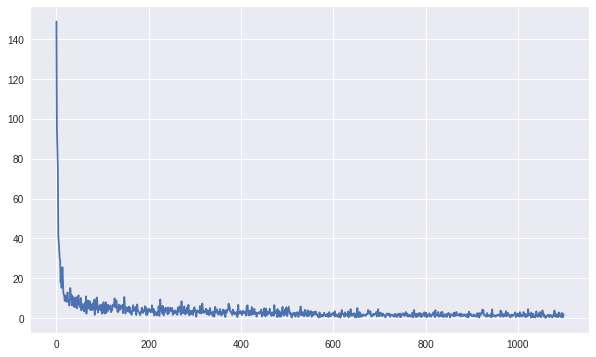

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(losses)
ax.grid(True)

In [19]:
_accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.test_images,
                                          Y_placeholder : mnist.test_labels
                                         })

print(str(round(100*_accuracy,2))+'%')

91.62%
